# Optimización de Rutas

## 1. Criación del Mapa

In [1]:
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

In [2]:
np.random.seed(42)

In [3]:
def crear_grafo_mina(n_nodes, n_bloqueos=1):
    """
    Crea un grafo geométrico donde algunos caminos están bloqueados.
    Los pesos de las aristas representan la distancia euclidiana.

    Retorna la matriz de distancias lista para el Hamiltoniano.
    """

    coords = np.random.rand(n_nodes, 2) * 100
    pos = {i: coords[i] for i in range(n_nodes)}

    dist_mat = distance_matrix(coords, coords)

    G = nx.complete_graph(n_nodes)
    nx.set_node_attributes(G, pos, "pos")

    lista_aristas = list(G.edges())
    indices_a_bloquear = np.random.choice(
        len(lista_aristas), size=n_bloqueos, replace=False
    )

    for i in indices_a_bloquear:
        u, v = lista_aristas[i]

        G.remove_edge(u, v)
        PENALTY = 9999.0
        dist_mat[u][v] = PENALTY
        dist_mat[v][u] = PENALTY

        print(f"> Bloqueo generado entre Ubicación {u} y {v}")

    for u, v in G.edges():
        G[u][v]["weight"] = dist_mat[u][v]

    return G, dist_mat, pos

In [4]:
import matplotlib.pyplot as plt

In [5]:
def plot_graph(G, pos):
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_color="orange", node_size=800)
    plt.title("Mapa de la Mina")
    plt.show()

In [6]:
N = 4

> Bloqueo generado entre Ubicación 1 y 3
> Bloqueo generado entre Ubicación 2 y 3
Grafo generado con 4 ubicaciones.
Ejemplo de distancia (Nodo 0 a Nodo 1): 50.17


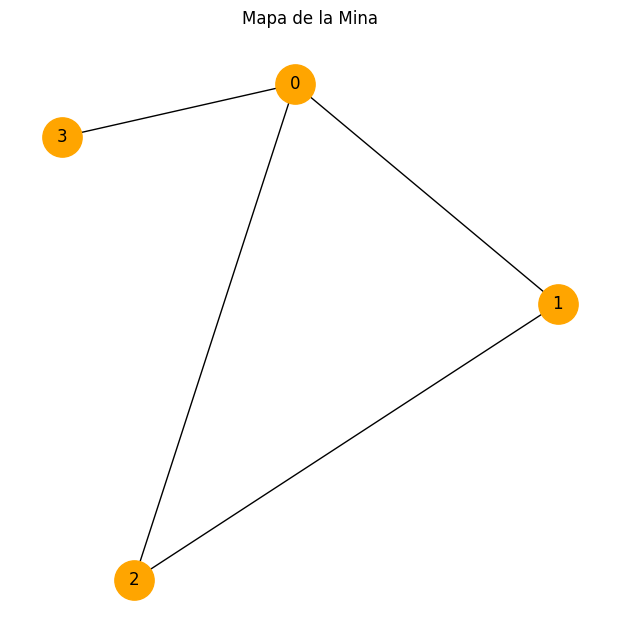

In [7]:
G_mina, matriz_distancias, posiciones = crear_grafo_mina(N, n_bloqueos=2)

print(f"Grafo generado con {N} ubicaciones.")
print("Ejemplo de distancia (Nodo 0 a Nodo 1):", f"{matriz_distancias[0][1]:.2f}")

plot_graph(G_mina, posiciones)

## 2. Programando el Problema Cuadrático

In [8]:
from dimod import BinaryQuadraticModel, BINARY
from typing import cast

In [9]:
def crear_hamiltoniano(
    dist_matrix: np.ndarray, A: float | None = None, B: float = 1.0
) -> BinaryQuadraticModel:
    """
    Construye el modelo BQM  para el problema de rutas.

    Args:
        dist_matrix (np.ndarray): Matriz N x N de distancias (con penalizaciones).
        A (float): Penalización por romper restricciones (Unicidad).
        B (float): Peso de la función de costo (Distancia).

    Returns:
        bqm (BinaryQuadraticModel): El modelo listo para resolver.
    """
    N = len(dist_matrix)

    max_dist = np.max(dist_matrix)
    if A is None:
        A = B * max_dist * 2.0
        print(f"Constante A calculada automáticamente: {A:.2f} (Max dist: {max_dist})")
    A = cast(float, A)

    bqm = BinaryQuadraticModel(BINARY)

    get_var = lambda i, t: f"x_{i}_{t}"

    for i in range(N):
        for t in range(N):
            var_name = get_var(i, t)
            bqm.add_variable(var_name, -2 * A)

    for t in range(N):
        for i in range(N):
            for j in range(i + 1, N):
                u = get_var(i, t)
                v = get_var(j, t)
                bqm.add_interaction(u, v, 2 * A)

    for i in range(N):
        for t in range(N):
            for k in range(t + 1, N):
                u = get_var(i, t)
                v = get_var(i, k)
                bqm.add_interaction(u, v, 2 * A)

    for t in range(N):
        next_t = (t + 1) % N

        for i in range(N):
            for j in range(N):
                if i != j:
                    dist = dist_matrix[i][j]

                    u = get_var(i, t)
                    v = get_var(j, next_t)

                    bqm.add_interaction(u, v, B * dist)

    return bqm

In [10]:
print("\n--- Construyendo Hamiltoniano ---")
bqm_mina = crear_hamiltoniano(matriz_distancias, A=None, B=1.0)

print(f"Modelo construido con {bqm_mina.num_variables} variables/qubits.")
print(f"Número de interacciones cuadráticas: {bqm_mina.num_interactions}")

var_salida = "x_0_0"
var_llegada = "x_1_1"
bias_cuadratico = bqm_mina.get_quadratic(var_salida, var_llegada)
distancia_real = matriz_distancias[0][1]

print("\nVerificación:")
print(f"Distancia física (0->1): {distancia_real}")
print(f"Acoplamiento J en BQM ({var_salida}, {var_llegada}): {bias_cuadratico}")


--- Construyendo Hamiltoniano ---
Constante A calculada automáticamente: 19998.00 (Max dist: 9999.0)
Modelo construido con 16 variables/qubits.
Número de interacciones cuadráticas: 96

Verificación:
Distancia física (0->1): 50.17136010769449
Acoplamiento J en BQM (x_0_0, x_1_1): 50.17136010769449


## 3. Preparando el Hamiltoniano de Ising y Ansatz

In [11]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import real_amplitudes
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from scipy.optimize import minimize

In [12]:
def bqm_to_qp(bqm: BinaryQuadraticModel) -> QuadraticProgram:
    """
    Traduce un BinaryQuadraticModel de dimod a un QuadraticProgram de Qiskit.
    """
    qp = QuadraticProgram(name="Optimización de Minería")

    for var in bqm.variables:
        qp.binary_var(name=str(var))

    linear_terms = {str(k): v for k, v in bqm.linear.items()}

    quadratic_terms = {(str(u), str(v)): val for (u, v), val in bqm.quadratic.items()}

    qp.minimize(linear=linear_terms, quadratic=quadratic_terms)

    return qp

In [13]:
def qp_to_ising(qp: QuadraticProgram) -> tuple[SparsePauliOp, float]:
    """
    Converte un QuadraticProgram a un problema de Ising.
    """
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(qp)
    ising = qubo.to_ising()

    return ising

In [14]:
def preparar_problema(
    bqm: BinaryQuadraticModel,
) -> tuple[SparsePauliOp, QuantumCircuit, float]:
    """
    Convierte el BinaryQuadraticModel a un operador Ising y define el Ansatz.
    """
    qp = bqm_to_qp(bqm)
    hamiltoniano, offset = qp_to_ising(qp)

    ansatz = real_amplitudes(
        num_qubits=hamiltoniano.num_qubits,
        entanglement="linear",
        reps=1,
    )
    ansatz = ansatz.decompose()

    print(f"Problema preparado: {hamiltoniano.num_qubits} Qubits.")
    print(f"Parámetros del Ansatz: {ansatz.num_parameters}")

    return hamiltoniano, ansatz, offset

In [15]:
observable, ansatz, offset = preparar_problema(bqm_mina)

Problema preparado: 16 Qubits.
Parámetros del Ansatz: 32


## 4. Ejecutando el VQE

In [16]:
class LogVQE:
    def __init__(self) -> None:
        self.conteos = []
        self.valores = []
        self.parametros = []
        self.iteracion = 0

    def update(self, xk):
        """Callback que llama SciPy en cada iteración."""
        self.iteracion += 1
        self.parametros.append(xk)

    def log_energia(self, energia):
        """Método auxiliar para guardar la energía desde la función de costo."""
        self.valores.append(energia)
        self.conteos.append(len(self.valores))

In [17]:
def cost_func_vqe(
    params,
    ansatz,
    hamilt,
    estimator: StatevectorEstimator,
    log_data: LogVQE,
):
    """
    Función objetivo para el optimizador clásico.
    Calcula el valor esperado <psi(theta)|H|psi(theta)>.
    """
    pub = (ansatz, [hamilt], [params])

    job = estimator.run([pub])
    result = job.result()

    energia = result[0].data.evs[0]
    log_data.log_energia(energia)

    return energia

In [18]:
def run_vqe(bqm: BinaryQuadraticModel, log: LogVQE):
    hamiltoniano, ansatz, offset = preparar_problema(bqm)

    print("Hamiltoniano de Ising listo para VQE:")
    print(f"Número de Qubits: {hamiltoniano.num_qubits}")

    estimator = StatevectorEstimator()

    num_params = ansatz.num_parameters
    init_params = 2 * np.pi * np.random.rand(num_params)

    print("Iniciando optimización VQE con COBYLA")
    res = minimize(
        cost_func_vqe,
        init_params,
        args=(ansatz, hamiltoniano, estimator, log),
        method="COBYLA",
        options={"maxiter": 300, "disp": True},
    )

    energia_final = res.fun + offset

    print("\nOptimización completada.")
    print(f"Energía mínima encontrada: {energia_final:.4f}")

    return res, log, ansatz, energia_final

In [19]:
log = LogVQE()
resultado_opt, historial, ansatz_opt, energia_total = run_vqe(bqm_mina, log)

Problema preparado: 16 Qubits.
Parámetros del Ansatz: 32
Hamiltoniano de Ising listo para VQE:
Número de Qubits: 16
Iniciando optimización VQE con COBYLA
Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 300   Least value of F = -331321.8501087013
The corresponding X is:
[ 6.29686936e+00  6.26666657e+00 -2.19847313e-02  6.27573399e+00
  3.11854170e+00  3.14517050e+00  3.42095845e-03  3.33419575e-03
  3.10537694e+00  3.14670682e+00 -2.30425037e-01  4.53162087e+00
  1.67058945e+00  2.62141045e+00  4.79887621e+00  4.70861534e+00
  6.25815288e+00  3.38317809e+00  6.46366099e+00  6.20115783e+00
  3.22893564e+00  2.16213208e-02  6.24733783e+00  3.11794881e+00
  3.07808420e+00  1.13965369e-01  2.94664350e+00  1.66342072e+00
  2.93960056e+00  2.67844543e+00  4.69647574e+00  1.51588221e+00]


Optimización completada.
Energía mínima encontrada: -130865.8678


## 5. Interpretar Resultados

In [28]:
from qiskit.primitives import StatevectorSampler
from matplotlib.lines import Line2D

In [29]:
def decodificar_ruta(
    bitstring: str,
    N: int,
    variables_index: dict[str, int],
) -> list[int]:
    """
    Traduce un bitstring '10010...' a una secuencia de nodos visitados.
    Args:
        bitstring (str): Resultado de la medición (ojo: Qiskit usa Little Endian).
        N (int): Número de ubicaciones.
        variables_index (dict): Mapeo {nombre_var: indice_qubit}.
    """
    bits = bitstring[::-1]

    ruta = [-1] * N

    for var_name, idx in variables_index.items():
        if bits[idx] == "1":
            partes = var_name.split("_")
            ubicacion_i = int(partes[1])
            tiempo_t = int(partes[2])

            if tiempo_t < N:
                ruta[tiempo_t] = ubicacion_i

    return ruta

In [30]:
def interpretar_solucion(ansatz, params_optimos, qp):
    """
    Ejecuta el circuito final y busca la solución más probable.
    """
    sampler = StatevectorSampler()

    circuito_medicion = ansatz.copy()
    circuito_medicion.measure_all()

    pub_medicion = (circuito_medicion, [params_optimos])
    job_med = sampler.run([pub_medicion])
    conteos = job_med.result()[0].data.meas.get_counts()

    mejor_bitstring = max(conteos, key=conteos.get)
    probabilidad = conteos[mejor_bitstring] / sum(conteos.values())

    print(f"Estado más probable: {mejor_bitstring} (Prob: {probabilidad:.2%})")

    var_map = {v.name: i for i, v in enumerate(qp.variables)}
    N = int(qp.get_num_vars() ** 0.5)

    ruta_decodificada = decodificar_ruta(mejor_bitstring, N, var_map)

    return ruta_decodificada, conteos

In [31]:
def graficar_convergencia(log_data):
    plt.figure(figsize=(10, 5))
    plt.plot(log_data.conteos, log_data.valores, color="purple", label="Energía VQE")
    plt.xlabel("Iteraciones (Evaluaciones de Costo)")
    plt.ylabel("Energía (Hamiltoniano)")
    plt.title("Convergencia del VQE hacia la Ruta Óptima")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [32]:
def visualizar_ruta_direccionada(G, pos, ruta_optima):
    """
    Dibuja el mapa de la mina resaltando la ruta encontrada con flechas direccionales.

    Args:
        G (nx.Graph): Grafo base de la mina (con todas las conexiones posibles).
        pos (dict): Coordenadas de los nodos.
        ruta_optima (list): Lista ordenada de nodos visitados (ej: [0, 2, 4...]).
        titulo (str): Título del gráfico.
    """
    plt.figure(figsize=(10, 8))

    nx.draw_networkx_nodes(G, pos, node_color="#e0e0e0", node_size=600, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color="#d3d3d3", style="dashed", alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_family="sans-serif", font_weight="bold")

    if -1 in ruta_optima:
        print(
            "¡La ruta contiene nodos inválidos (-1)! No se puede graficar correctamente."
        )
        return

    aristas_ruta = []
    num_pasos = len(ruta_optima)

    print(f"Secuencia de visita: {ruta_optima} -> {ruta_optima[0]} (Ciclo)")

    for i in range(num_pasos):
        origen = ruta_optima[i]
        destino = ruta_optima[(i + 1) % num_pasos]
        aristas_ruta.append((origen, destino))

    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=aristas_ruta,
        edge_color="#D9534F",
        width=3.0,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=25,
        connectionstyle="arc3,rad=0.1",
    )

    for i, (u, v) in enumerate(aristas_ruta):
        x_medio = (pos[u][0] + pos[v][0]) / 2
        y_medio = (pos[u][1] + pos[v][1]) / 2

        plt.text(
            x_medio,
            y_medio,
            f"{i + 1}",
            fontsize=10,
            color="white",
            fontweight="bold",
            bbox=dict(boxstyle="circle,pad=0.3", fc="#D9534F", ec="none", alpha=0.8),
        )

    nodo_inicio = ruta_optima[0]
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[nodo_inicio],
        node_color="#5CB85C",
        node_size=800,
        label="Inicio/Fin",
    )

    plt.title("Ruta Óptima de la Flota", fontsize=14)
    plt.axis("off")

    leyenda_elementos = [
        Line2D([0], [0], color="#D9534F", lw=3, label="Ruta Óptima (VQE)"),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="#5CB85C",
            markersize=12,
            label="Punto de Inicio",
        ),
        Line2D(
            [0], [0], color="#d3d3d3", lw=1, linestyle="--", label="Caminos Disponibles"
        ),
    ]
    plt.legend(handles=leyenda_elementos, loc="lower right")
    plt.show()

In [33]:
qp_mina = bqm_to_qp(bqm_mina)
ruta_final, dist_prob = interpretar_solucion(ansatz, resultado_opt.x, qp_mina)
print("Ruta encontrada:", ruta_final)

Estado más probable: 0001010010000010 (Prob: 51.66%)
Ruta encontrada: [3, 0, 2, 1]


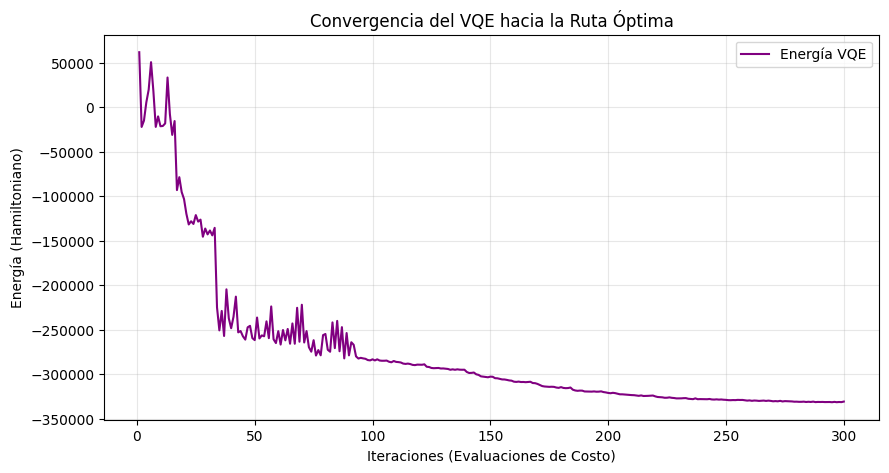

In [34]:
graficar_convergencia(log)

Secuencia de visita: [3, 0, 2, 1] -> 3 (Ciclo)


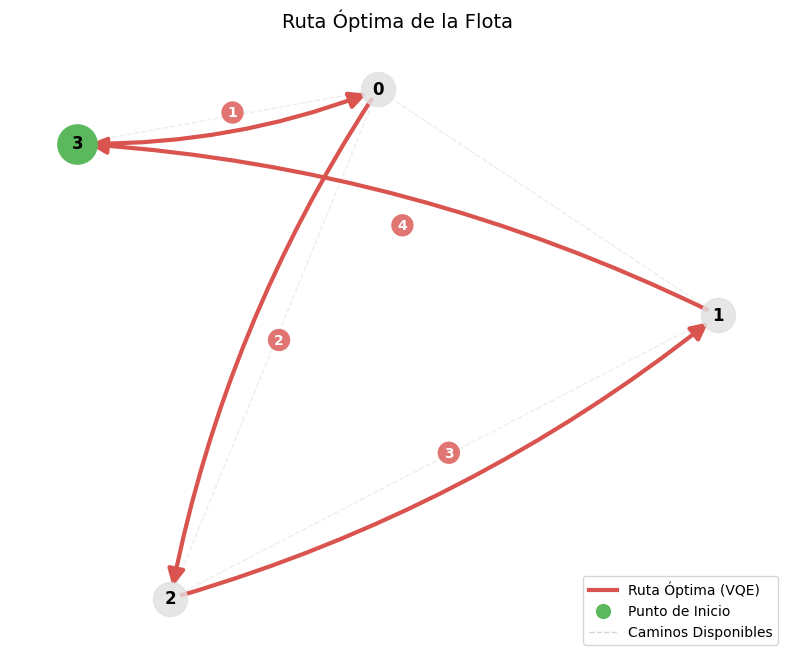

In [35]:
visualizar_ruta_direccionada(G_mina, posiciones, ruta_final)